In [1]:
!pip install netcdf4

Defaulting to user installation because normal site-packages is not writeable


In [26]:
import os
import itertools
import json

import numpy as np
import matplotlib.pyplot as plt

import DeepMice.utils.data_loader as dl

In [63]:
def get_trial_matrix_2d(data, output='image_index',n_frame=10):
  """Calculate 2D trial matrix (trials, neurons) from loaded data
  Input:
    data: xarray for one session
    output: str   (description of the type of variable)
          Supported choices: image_index, is_change, rewarded
  Output:
    trial_matrix_2d: (trials, neurons)
    y: 1d array (trials) 
    
  Adpated from DeepMice.utils.data_loader.get_trial_matrix_3d by @AdrianHoffmann
  """
  # use descriptive variables for the dimensions
  nr_trials = len(data.trial)
  nr_neurons = data.activity.shape[0]

  trial_matrix_2d = np.zeros((nr_trials, nr_neurons))
  y = np.zeros(nr_trials)

  for i in range(nr_trials):
    # extract the neural activity 
    start_idx = int( data.start_frame[i] )   # frame of trial start
    trial_matrix_2d[i,:] = np.mean(data.activity.data[:,start_idx:start_idx+n_frame], axis=1)
    
    # select the predictor that should be used
    if output == 'image_index':
      y[i] = data.image_index[i]
    elif output == 'is_change':
      y[i] = data.is_change[i]
    elif output == 'rewarded':
      y[i] = data.rewarded[i]
    else:
      raise Exception('Argument for output="{}" not supported.'.format(output))
  
  return trial_matrix_2d, y

In [3]:
# read file names 
data_path = '/home/nu/fcheng/AllenSDKData_mice/session_data'
fn_list = sorted([fn for fn in os.listdir(data_path) if fn.endswith('.nc')])
num_session = len(fn_list)
num_session

52

In [64]:
# merge sessions for each cool mouse
mice = dict()
for fn in fn_list:
    ses = dl.load_one_session(os.path.join(data_path, fn))
    mouse_id = str(ses.attrs['mouse_id'])
    neuron_id = ses.coords['neuron_id']
    activity_avg, image_index = get_trial_matrix_2d(ses, output='image_index',n_frame=5)
    if mouse_id not in mice.keys():
        mice[mouse_id] = dict()
        mice[mouse_id]['activity'] = [activity_avg.T]
        mice[mouse_id]['neuron_id'] = [neuron_id]
        mice[mouse_id]['image_index'] = [image_index]
    else: 
        mice[mouse_id]['activity'].append(activity_avg.T)
        mice[mouse_id]['neuron_id'].append(neuron_id)
        mice[mouse_id]['image_index'].append(image_index)

print('We have {} mice:{}'.format(len(mice.keys()), [ID for ID in mice.keys()]))

We have 23 mice:['403491', '412366', '425496', '425493', '431023', '431252', '440298', '445270', '436662', '445002', '447663', '450471', '451787', '453913', '456916', '456917', '456915', '453911', '459773', '459777', '484627', '479839', '485152']


In [124]:
for ID in mice.keys():
    
    cool_mouse = mice[ID]
    num_ses = len(cool_mouse['image_index'])
    #print('Number of session for mouse {} is: {}\n'.format(ID, num_ses))
    
    #initialize matrix (#neurons X #trials)
    neuron_id_list = cool_mouse['neuron_id'] 
    neuron_id_unique = np.unique(list(itertools.chain(*neuron_id_list)))
    num_neuron = len(neuron_id_unique)
    
    num_trial_list = [image_index.shape[0] for image_index in cool_mouse['image_index']]
    num_trial = sum(num_trial_list)
    
    data_merge = np.ones((num_neuron, num_trial))*(-10e-2)
    #print('The size of merged activity matrix (neuron X trial): ({},{})\n'.format(num_neuron, num_trial))
    
    if num_ses == 1:
        data_merge = cool_mouse['activity'][0]
    else:
        # add data according to neuron_id
        col_end = 0
        for i in range(num_ses):
            
            #update column index
            col_start = col_end
            col_end = col_end + num_trial_list[i]

            activity = cool_mouse['activity'][i]

            neuron_id_i = np.array(neuron_id_list[i]) #the ith session
            for j,neuron_id in enumerate(neuron_id_i):
                data_merge[np.where(neuron_id_unique==neuron_id), col_start:col_end] = activity[j,:]
    
    mice[ID]['merge_data'] = data_merge

np.save('/home/nu/fcheng/AllenSDKData_mice/mice_210813.npy', mice) 

In [103]:
mice.keys()

dict_keys(['403491', '412366', '425496', '425493', '431023', '431252', '440298', '445270', '436662', '445002', '447663', '450471', '451787', '453913', '456916', '456917', '456915', '453911', '459773', '459777', '484627', '479839', '485152'])

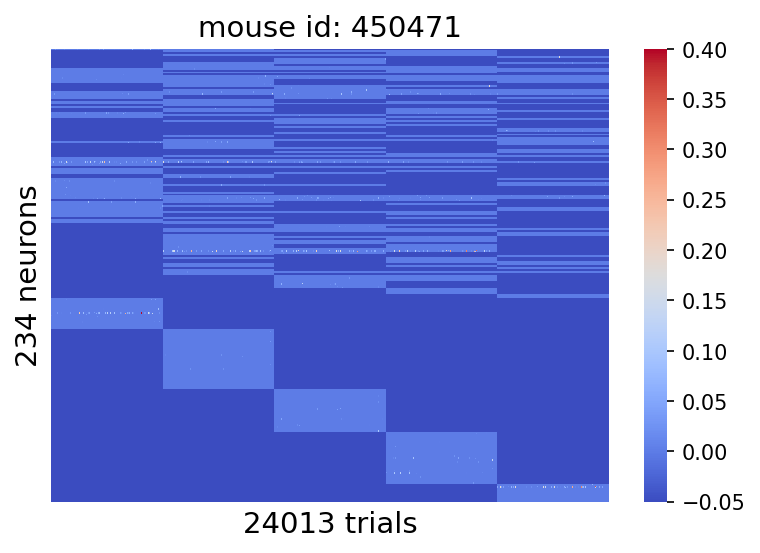

In [193]:
# plot 
import seaborn as sns
ID = '450471'
plt.figure(figsize=(6, 4), dpi=150)
ax = sns.heatmap(mice[ID]['merge_data'], vmin=-0.05, vmax = 0.4, cmap="coolwarm")#"YlGnBu"
ax.set_xticks([])
ax.set_yticks([])
plt.xlabel(str(mice_merge_seesion[ID].shape[1])+' trials', fontsize = 14)
plt.ylabel(str(mice_merge_seesion[ID].shape[0])+' neurons', fontsize = 14)
plt.title('mouse id: ' + ID, fontsize = 14)
plt.show()


In [24]:
ses_list[0]

<xarray.Dataset>
Dimensions:      (images_id: 8, neuron_id: 89, time: 149472, trial: 4790, x: 1200, y: 1920)
Coordinates:
  * neuron_id    (neuron_id) int64 1086489529 1086489533 ... 1086491480
  * time         (time) float64 2.268 2.3 2.332 ... 4.831e+03 4.831e+03
  * trial        (trial) int64 1 2 3 4 5 6 7 ... 4706 4707 4708 4709 4710 4711
  * images_id    (images_id) object 'im065' 'im077' 'im066' ... 'im085' 'im069'
  * x            (x) int64 0 1 2 3 4 5 6 ... 1193 1194 1195 1196 1197 1198 1199
  * y            (y) int64 0 1 2 3 4 5 6 ... 1913 1914 1915 1916 1917 1918 1919
Data variables:
    activity     (neuron_id, time) float32 ...
    start_frame  (trial) int64 ...
    start_time   (trial) float64 ...
    image_index  (trial) int64 ...
    image_name   (trial) object ...
    is_change    (trial) bool ...
    rewarded     (trial) bool ...
    running      (time) float64 ...
    pupil        (time) float64 ...
    blinking     (time) bool ...
    licking      (time) bool ...
    reward       (time) bool ...
    images       (images_id, x, y) uint8 ...
Attributes:
    mouse_id:             403491
    cre_line:             Slc17a7-IRES2-Cre
    ophys_session_id:     775289198
    session_type:         OPHYS_1_images_A
    frame_rate_Hz:        31.0
    day_of_experiment:    2018-11-08
    easy_session_number:  0
    version:              1

In [71]:
data_merge

array([[4.68332134e-03, 1.68168413e-11, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])